# sumaryzacja tekstu

In [1]:
from google.colab import drive


drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon Jan 26 16:40:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install "datasets<3.0.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [ ]:
!pip install bert-extractive-summarizer

In [4]:
!pip install pytorch-ignite
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 30.2 MB/s eta 0:00:00


## importowanie datesetu

In [130]:
from datasets import load_dataset


ds = load_dataset("xsum", trust_remote_code=True)
ds= ds.filter(lambda example: len(example["document"]) < 750)
split_result = ds["test"].train_test_split(test_size=2, seed=42)
shots = split_result["test"]
ds["test"] = split_result["train"]

Using the latest cached version of the dataset since xsum couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/xsum/default/0.0.0/7d4d486c2f8ef850b1a11aead99b894ff3dd7da9 (last modified on Mon Jan 26 18:57:48 2026).


In [69]:
print(ds)
print(shots)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 84554
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4689
    })
})
Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 2
})


In [ ]:
from summarizer import Summarizer
model = Summarizer()

In [8]:
from ignite.metrics import Rouge

m = Rouge(variants=["L", 1], multiref="best")

candidate = "the cat is not there".split()
references = [
    "the cat is on the mat".split(),
    "there is a cat on the mat".split()
]

m.update(([candidate], [references]))

print(m.compute())

{'Rouge-L-P': 0.6, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5, 'Rouge-1-P': 0.8, 'Rouge-1-R': 0.5714285714285714, 'Rouge-1-F': 0.5714285714285714}


In [100]:
num_workers = 1
batch_size = 3

In [101]:
from torch.utils.data import DataLoader
import torch
test_dataset = ds["test"].select(range(10))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(test_dataset)


Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 10
})


In [73]:
import string


def clean(text):
    if not text:
        return ["."]
    text = text.lower().translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )
    return text.split()


def rouge_score_loss(
    batch,
    model,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    m=Rouge(variants=["L", 2], multiref="best"),
):
    if bert:
        predictions = [
            model(doc, ratio=0.1) for doc in batch["document"]
        ]
    else:
        docs = [doc for doc in batch["document"]]

        prompted = [
            f"{prompt}{doc}{promptsuff}" for doc in batch["document"]
        ]
        inputs = tokenizer(
            prompted,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=4096,
        )

        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            do_sample=True,
            top_k=0,
            temperature=0.5,
        )

        input_length = inputs["input_ids"].shape[1]
        new_tokens = summary_ids[:, input_length:]

        predictions = tokenizer.batch_decode(
            new_tokens, skip_special_tokens=True
        )

    print(f"Doc: {batch['document'][0][:100]}")
    print(f"Prediction: {predictions[0]}")
    print(f"Target: {batch['summary'][0]}")

    predictions = [
        clean(pred) if pred.strip() else "." for pred in predictions
    ]

    targets = [[clean(ref)] for ref in batch["summary"]]

    print(predictions)
    print(targets)

    m.update((predictions, targets))
    print(m.compute())
    return m.compute()

In [86]:
from matplotlib import pyplot as plt
import numpy as np

def plot_data(data, labels=['Rouge-1-P', 'Rouge-1-R', 'Rouge-1-F','Rouge-2-P', 'Rouge-2-R', 'Rouge-2-F',  'Rouge-L-P', 'Rouge-L-R', 'Rouge-L-F', ]):
    x = np.arange(len(labels))
    width = 0.2

    plt.figure(figsize=(10, 6))
    for i, row in enumerate(data):
        offset = x + (i * width)
        plt.bar(offset, row, width=width, label=f'Model {i+1}')
    center_offset = ((len(data) - 1) * width) / 2
    plt.xticks(x + center_offset, labels)

    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('ROUGE Score Comparison')
    plt.legend()
    plt.show()

In [11]:
def batch_to_device(batch: dict, device) -> dict:
    return {k: v.to(device) for k, v in batch.items()}

In [12]:
import torch
import torch.nn as nn
from torch import Tensor
def calc_loss_batch(batch: dict, model: nn.Module) -> Tensor:
    logits = model(batch['input_ids'])
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), batch['labels'].flatten())
    return loss

In [87]:
import numpy as np
def calc_loss_loader(
    data_loader,
    model,
    device,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
) -> float:
    results = []

    for i, batch in enumerate(data_loader):

        m = Rouge(variants=[1,2,"L"], multiref="best")

        ret = rouge_score_loss(
            batch,
            model,
            bert,
            tokenizer,
            prompt,
            promptsuff,
            m,
        )
        results.append(list(ret.values()))

    results = np.array(results)
    return np.mean(results, axis=0)


In [16]:
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device,
    bert: bool,
    tokenizer: any,
    prompt: str = "",
    promptsuff: str = "",
) -> tuple[float, float]:
    if not bert:
        model.eval()

    with torch.no_grad():
        loss = calc_loss_loader(
            loader,
            model,
            device,
            bert=bert,
            tokenizer=tokenizer,
            prompt=prompt,
            promptsuff=promptsuff,
        )

    return loss




In [ ]:
from torch import nn
loss = evaluate_model(model, test_loader, device='cuda', bert=True, tokenizer=None)
print(loss)



In [121]:
def generate_prompt(tokenizer, size):
    prompt = ""
    shots = ds["train"].train_test_split(train_size=4, seed=35)["train"]
    shots_loader = DataLoader(shots, batch_size=100000, shuffle=True, num_workers=num_workers)
    for batch in shots_loader:
        for i in range(len(batch['document'])):
            prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer."
            prompt += f'[TEXT]{batch['document'][i]}[AGENT]{batch['summary'][i]}'
            prompt += tokenizer.eos_token + "\n"
    prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
    return prompt


In [26]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer3 = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-0.5B")
tokenizer3.padding_side = 'left'
if tokenizer3.pad_token is None:
    tokenizer3.pad_token = tokenizer3.eos_token
    # Some models also require explicitly setting the pad_token_id
    tokenizer3.pad_token_id = tokenizer3.eos_token_id
model3 = AutoModelForCausalLM.from_pretrained("Qwen/Qwen1.5-0.5B")




config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [131]:
prompt3 = generate_prompt(tokenizer3, 2)
print(prompt3)

[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]The 27-year-old had a year left on his Dons deal, but has signed a one-year contract with his new club with an option for another 12 months.
Having been on loan at Aberdeen in 2015-16, the Amersham-born player has now parted company with the Dons, who were relegated to League One last term.
Church joined MK Dons in June 2015 after leaving Charlton.
Find all the latest football transfers on our dedicated page.[AGENT]Wales striker Simon Church has left MK Dons to join Dutch club Roda JC for an unspecified fee.<|endoftext|>
[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]Ibe, who joined from Liverpool for £15m, struck after 12 minutes with a driving run and a curling finish.
Cardiff kept possession well but created few chances, with Joe Ralls' low wide shot their best effort.
The Bluebirds' opening league game is at Birmingham on Sat

In [132]:

data = evaluate_model(model3, test_loader, device='cuda', bert=False, tokenizer=tokenizer3, prompt=prompt3, promptsuff = "[AGENT]")

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: If you have a picture you would like to share, please see below the images for details on how to sub
Prediction: If you have a picture of something that you'd like to share with us, you can send it to us using the contact details below. You can also send us your pictures through our Facebook page. Alternatively, you can email us at england@
Target: Each day we feature a photograph sent in from across England - the gallery will grow during the week.
[['if', 'you', 'have', 'a', 'picture', 'of', 'something', 'that', 'you', 'd', 'like', 'to', 'share', 'with', 'us', 'you', 'can', 'send', 'it', 'to', 'us', 'using', 'the', 'contact', 'details', 'below', 'you', 'can', 'also', 'send', 'us', 'your', 'pictures', 'through', 'our', 'facebook', 'page', 'alternatively', 'you', 'can', 'email', 'us', 'at', 'england'], ['a', 'man', 'has', 'appeared', 'in', 'court', 'charged', 'with', 'causing', 'serious', 'injury', 'to', 'a', '31', 'year', 'old', 'woman', 'in', 'a', 'crash', 'in', 'which', 'a', 'mo

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: "What time does your website close?" in Poole and "Can I exercise my kestrel on your tip?" in Nottin
Prediction: Hundreds of people have been calling the police in Poole, Wiltshire, to find out when their website will close. Some are asking for the date, while others are inquiring about whether they are entitled to any tax relief. Others are trying
Target: Questions on everything from James Bond villains to Great British Bake Off cake tins have been received by council call centres in England.
[['hundreds', 'of', 'people', 'have', 'been', 'calling', 'the', 'police', 'in', 'poole', 'wiltshire', 'to', 'find', 'out', 'when', 'their', 'website', 'will', 'close', 'some', 'are', 'asking', 'for', 'the', 'date', 'while', 'others', 'are', 'inquiring', 'about', 'whether', 'they', 'are', 'entitled', 'to', 'any', 'tax', 'relief', 'others', 'are', 'trying'], ['scotland', 's', 'independence', 'referendum', 'is', 'now', 'over', 'in', 'favour', 'of', 'leaving', 'the', 'eu', 'but', 'what', 'are', 

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: Chief executive Karl Koehler is standing down and his replacement will not have a position on the ma
Prediction: Tata Steel is to pay a Â£300m severance package to the 1,050 workers who were sacked last month. The company has also reduced its European operations. But the move has raised questions about the future of
Target: Changes at the top of Tata Steel Europe raise doubts about the "long-term investment" of the company, according the steelworkers union, Community.
[['tata', 'steel', 'is', 'to', 'pay', 'a', 'â£300m', 'severance', 'package', 'to', 'the', '1', '050', 'workers', 'who', 'were', 'sacked', 'last', 'month', 'the', 'company', 'has', 'also', 'reduced', 'its', 'european', 'operations', 'but', 'the', 'move', 'has', 'raised', 'questions', 'about', 'the', 'future', 'of'], ['all', 'images', 'courtesy', 'of', 'bbc', 'scotland', 'please', 'remember', 'that', 'you', 'are', 'being', 'asked', 'to', 'submit', 'images', 'that', 'are', 'not', 'your', 'own', 'do', 'not', 'submit', 'i

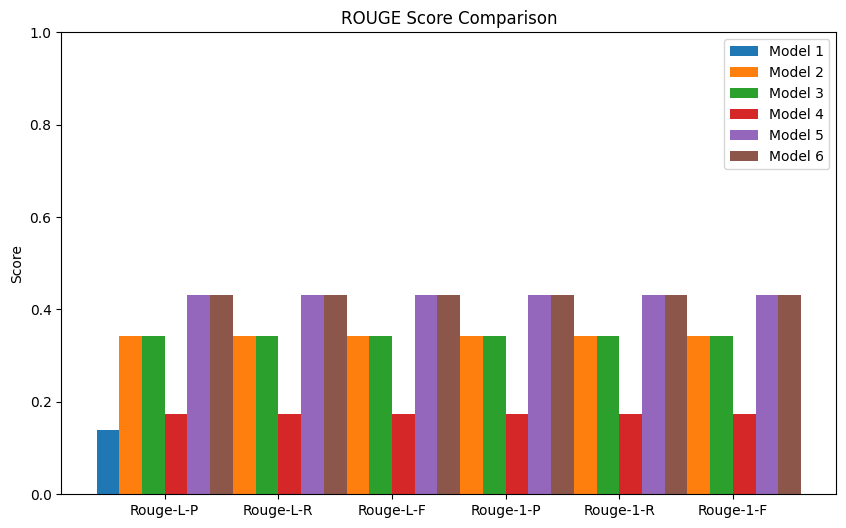

In [75]:
plot_data(data)

In [ ]:
prompt4 = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
data_zero_shot = evaluate_model(
        model3,
        test_loader,
        device="cuda",
        bert=False,
        tokenizer=tokenizer3,
        prompt=prompt4,
        promptsuff = "[AGENT]"
    )


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Doc: In less than 24 hours, the country's chosen to leave the European Union, abandoning an institution, 
Prediction: The Brexit vote has been a very different experience than the one that led to the UK's decision to leave the EU in 2001. But it is not just a question of opinion that has changed. It is the way the electorate has
Target: Tourists and members of the public drifted to Westminster's College Green - to witness this day, and also, perhaps, just to make sense of what's going on.
[['the', 'brexit', 'vote', 'has', 'been', 'a', 'very', 'different', 'experience', 'than', 'the', 'one', 'that', 'led', 'to', 'the', 'uk', 's', 'decision', 'to', 'leave', 'the', 'eu', 'in', '2001', 'but', 'it', 'is', 'not', 'just', 'a', 'question', 'of', 'opinion', 'that', 'has', 'changed', 'it', 'is', 'the', 'way', 'the', 'electorate', 'has'], ['yorkshire', 'have', 'appointed', 'former', 'england', 'women', 's', 'rugby', 'coach', 'nicola', 'grayson', 'as', 'their', 'first', 'female', 'coach', 'she', '

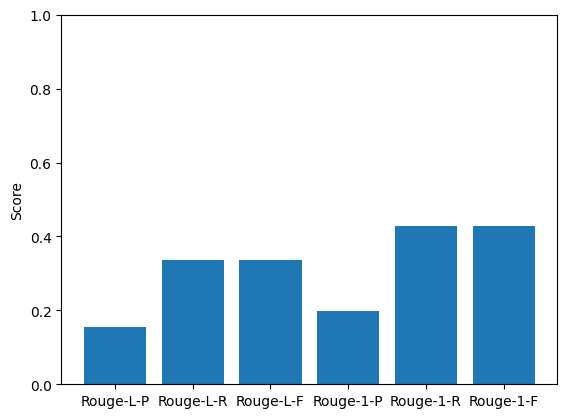

In [51]:
plot_data(data_zero_shot)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
from peft import PeftModel
model_path = './drive/MyDrive/models/ft'
ft_model = PeftModel.from_pretrained(model3, model_path)


In [ ]:
data_ft = evaluate_model(ft_model, test_loader, 'cuda', bert=False, tokenizer = tokenizer3, prompt = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]", promptsuff = "[AGENT]")

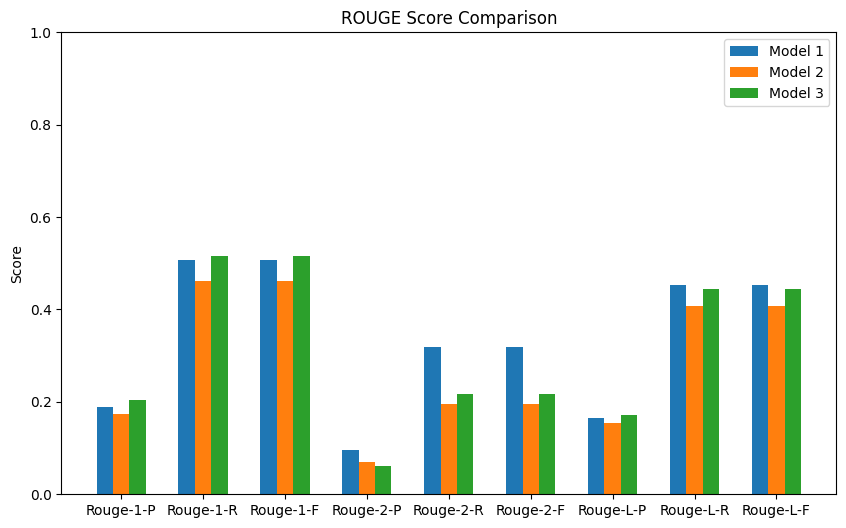

[0.20482084 0.51530366 0.51530366 0.06222525 0.21778742 0.21778742
 0.17071638 0.44451346 0.44451346]
[0.18830599 0.50730101 0.50730101 0.09577124 0.31783199 0.31783199
 0.16458239 0.45236945 0.45236945]


In [124]:
plot_data([data_ft, data, data_zero_shot])
print(data_zero_shot)
print(data_ft)